# Heat and FW Buoyancy Fluxes

This file makes Figure 6 for the paper - deisgned to show that buoyancy fluxes over the Antarctic continenta shelf in the Easterlies experiment is dominaed by freshwater fluxes.

To do this, we calculate the climatology of the fluxes over years 5-10 of the control, up and down experiments (noting that the annual cycle of buoyancy fluxes are highly repeatable).

We plot both the total buoyancy flux and the anomalies.

**Andy Hogg 18 Nov 2021**

In [62]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import cftime
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [63]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34157/status,
Dashboard: /proxy/34157/status,Workers: 7
Total threads: 28,Total memory: 125.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42219,Workers: 7
Dashboard: /proxy/34157/status,Total threads: 28
Started: Just now,Total memory: 125.21 GiB
Comm: tcp://127.0.0.1:39263,Total threads: 4
Dashboard: /proxy/35051/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:38017,


**Use the default database, and control, WIND+ and WIND- experiments**

In [64]:
session = cc.database.create_session()

# Control
control = '01deg_jra55v13_ryf9091'
# 10% increase in easterly wind speed: WIND+
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed: WIND-
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'

lat_slice  = slice(-85,-59)

In [65]:
plt.rcParams['font.size'] = 14

## Topography and grid data
Load static data and make a shelf mask.

In [66]:
ht = cc.querying.getvar(control,'ht',session,n=1).sel(yt_ocean=lat_slice).load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

st_ocean = cc.querying.getvar(control,'st_ocean',session,n=1).load()
geolon_t = cc.querying.getvar(control,'geolon_t',session, n=1).sel(yt_ocean=lat_slice).load()
geolat_t = cc.querying.getvar(control,'geolat_t',session, n=1).sel(yt_ocean=lat_slice).load()
yt_ocean = ht.yt_ocean
xt_ocean = ht.xt_ocean

In [67]:
# load proper 1000 m isobath mask:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)]).sel(yt_ocean=lat_slice)

In [68]:
area_t = cc.querying.getvar(control, 'area_t', session,n=1).sel(yt_ocean=lat_slice).load()
area_sum = (area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'}).load()

## Set specific heat capacity

In [69]:
C_p = 3992.1

## Function to calculate  net surface heat flux
* The relevant heat flux terms are:

`heat flux = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme +sfc_hflux_from_runoff) + frazil_3d_int_z [calving=0?]`

where () terms are in net_sfc_heating. Calculation is in W/m^2

* We then use gsw routines (code thanks to Ruth Moorman) to use, SST, pressure and SS to give a local thermal expansion coefficient and divide by C_p (defined above). When multiplied by surface fluxes this give buoyancy flux in kg/m^2/s. 

* This buoyancy flux is then averaged over shelf area.


In [70]:
def net_heat_buoyancy_flux(expt):
    swflx = cc.querying.getvar(expt, 'swflx', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    lw_heat = cc.querying.getvar(expt, 'lw_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sens_heat = cc.querying.getvar(expt, 'sens_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    evap_heat = cc.querying.getvar(expt, 'evap_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    fprec_melt_heat = cc.querying.getvar(expt, 'fprec_melt_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly',start_time=start_time, end_time=end_time)

    SST = cc.querying.getvar(control, 'surface_temp', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)-273.15
    depth_tile = -(geolat_t*0+1)*st_ocean[0].values
    pressure = xr.DataArray(p_from_z(depth_tile,geolat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    SSS_PSU = cc.querying.getvar(control, 'surface_salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,geolon_t,geolat_t), coords = [SSS_PSU.time, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    thermal_expansion  = xr.DataArray(alpha(SSS, SST, pressure), coords = [SSS_PSU.time, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient ', attrs = {'units':'1/K'})

    net_sfc_heating_ts = (((swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z)*(thermal_expansion/C_p)*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/area_sum).load()
    return net_sfc_heating_ts

## Function to calculate net Freshwater flux

* FW flux, in kg/s/m^2, is given by:

`fwflux = (lprec + fprec + river + evap + melt) - (sfc_salt_flux_ice + sfc_salt_flux_restore)`

* gsw routines are used to get both sea surface absolute salinity (g/kg) and haline contraction coefficient (kg/g). The product of these converts FW flux to buoyancy flux (without changing units.

* Fluxes are averaged over the shelf region.

In [71]:
def net_fw_buoyancy_flux(expt):
    lprec = cc.querying.getvar(expt, 'lprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    fprec = cc.querying.getvar(expt, 'fprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    evap = cc.querying.getvar(expt, 'evap', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    river = cc.querying.getvar(expt, 'river', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    melt = cc.querying.getvar(expt, 'melt', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)

    # Get Haline contraction coefficient -- Ruth's code
    SST = cc.querying.getvar(control, 'surface_temp', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)-273.15
    depth_tile = -(geolat_t*0+1)*st_ocean[0].values
    pressure = xr.DataArray(p_from_z(depth_tile,geolat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    SSS_PSU = cc.querying.getvar(control, 'surface_salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,geolon_t,geolat_t), coords = [SSS_PSU.time, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [SSS_PSU.time, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})

    net_sfc_fw_flux_ts = (((lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore)*(haline_contraction*SSS)*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/area_sum).load()
    return net_sfc_fw_flux_ts

In [72]:
print('Haline contraction coefficient is roughly %f'%beta(34.5, 2, 0))

Haline contraction coefficient is roughly 0.000775


## Calculate fluxes

In [73]:
net_sfc_heat_buoyancy_control = net_heat_buoyancy_flux(control)
net_sfc_heat_buoyancy_up = net_heat_buoyancy_flux(easterlies_up)
net_sfc_heat_buoyancy_down = net_heat_buoyancy_flux(easterlies_down)

In [74]:
net_fw_buoyancy_flux_control = net_fw_buoyancy_flux(control)
net_fw_buoyancy_flux_up = net_fw_buoyancy_flux(easterlies_up)
net_fw_buoyancy_flux_down = net_fw_buoyancy_flux(easterlies_down)

## Plot output as climatology

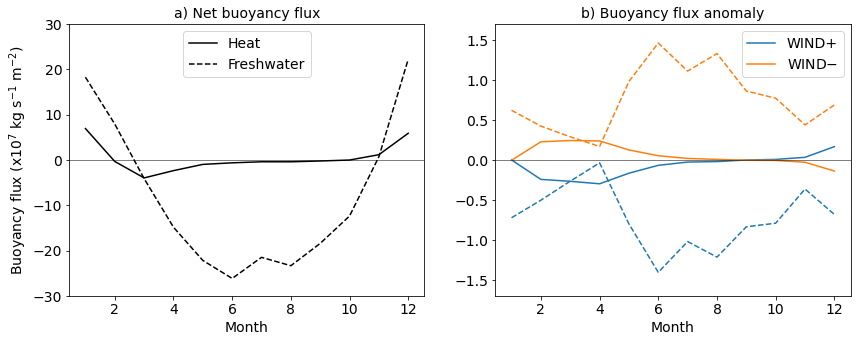

In [85]:
plt.figure(figsize=(14,5))
plt.subplot(121)

(net_sfc_heat_buoyancy_control.groupby('time.month').mean('time')*1e7).plot(color='k',label='Heat')
plt.ylabel('Buoyancy Flux (kg/s/m$^2$)')

(net_fw_buoyancy_flux_control.groupby('time.month').mean('time')*1e7).plot(color='k',linestyle='--',label='Freshwater')
plt.title('a) Net buoyancy flux',fontsize=14)
plt.ylabel('Buoyancy flux (x10$^7$ kg s$^{-1}$ m$^{-2}$)')
plt.xlabel('Month')

plt.axhline(0,color='k',linewidth=0.5)
plt.ylim(-30,30)
#plt.yticks([-20,0,20])
plt.legend(loc=9)

plt.subplot(122)
climatology = net_sfc_heat_buoyancy_control.groupby('time.month').mean('time')
#(climatology*0).plot(color='k',label='CONTROL',linewidth=0.5)
((net_sfc_heat_buoyancy_up.groupby('time.month').mean('time')-climatology)*1e7).plot(label='WIND+')
((net_sfc_heat_buoyancy_down.groupby('time.month').mean('time')-climatology)*1e7).plot(label='WIND$-$')
plt.legend()

climatology = net_fw_buoyancy_flux_control.groupby('time.month').mean('time')
#(climatology*0).plot(color='k',linestyle='--',label='CONTROL')
((net_fw_buoyancy_flux_up.groupby('time.month').mean('time')-climatology)*1e7).plot(color='C0',linestyle='--',label='WIND+')
((net_fw_buoyancy_flux_down.groupby('time.month').mean('time')-climatology)*1e7).plot(color='C1',linestyle='--',label='WIND$-$')

plt.axhline(0,color='k',linewidth=0.5)
plt.ylim(-1.7,1.7)
plt.title('b) Buoyancy flux anomaly',fontsize=14)
plt.xlabel('Month')

figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'
plt.savefig(figdir +'Figure6.pdf',bbox_inches = 'tight')

In [22]:
net_fw_buoyancy_flux_control.mean('time')

<xarray.DataArray ()>
array(-1.16793013e-06)

In [23]:
net_fw_buoyancy_flux_up.mean('time')

<xarray.DataArray ()>
array(-1.28513541e-06)

In [24]:
net_fw_buoyancy_flux_down.mean('time')

<xarray.DataArray ()>
array(-1.04479058e-06)